In [1]:
import pliar.common as cmn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

In [2]:
interaction_data = pd.read_csv(
    cmn.DATA_PATH / "processed" / "plip" / "all_interactions.csv"
)
kinodata3d = cmn.get_kinodata3d_source_df().rename(
    columns={"activity_id": cmn.COLS.ACTIVITY_ID}
)
by_activity = kinodata3d.set_index(cmn.COLS.ACTIVITY_ID)

In [3]:
interaction_data

,RESNR,RESTYPE,activities.activity_id,ITR_TYPE,similar.klifs_structure_id,ITR_TYPE_INDEX
0,48,LEU,23227035,HBOND-A,14808,0
1,48,MET,2111945,HBOND-A,2272,0
2,24,GLU,24850809,HBOND-A,1942,0
3,4,GLY,17625598,HBOND-A,14284,0
4,46,GLU,17625598,HBOND-A,14284,0
...,...,...,...,...,...,...
1040892,17,LYS,16394879,PI_CATION,5319,5
1040893,17,LYS,2120608,PI_CATION,5341,5
1040894,17,LYS,2120608,PI_CATION,5341,5
1040895,17,LYS,17627289,PI_CATION,11596,5


In [4]:
def create_ifp_data(
    interaction_data: pd.DataFrame,
    by_activity: pd.DataFrame,
    binary: bool = True,
    group_key="similar.klifs_structure_id",
):
    n = interaction_data[cmn.COLS.ACTIVITY_ID].nunique()
    fingerprints = np.zeros((n, 6, 85))
    activities = np.zeros(n)
    groups = []
    activity_ids = []
    if not isinstance(group_key, list):
        group_key = [group_key]
    for i, (act_id, group) in enumerate(interaction_data.groupby(cmn.COLS.ACTIVITY_ID)):
        for _, row in group.iterrows():
            if binary:
                fingerprints[i, row["ITR_TYPE_INDEX"], row["RESNR"] - 1] = 1
            else:
                fingerprints[i, row["ITR_TYPE_INDEX"], row["RESNR"] - 1] += 1
        activity_ids.append(act_id)
        try:
            activities[i] = by_activity.loc[act_id, "activities.standard_value"]
            group = []
            for _group_key in group_key:
                group.append(by_activity.loc[act_id, _group_key])
            groups.append(tuple(group))
        except KeyError:
            activities[i] = float("nan")
            groups.append(None)
    fp_data = pd.DataFrame(fingerprints.reshape(n, -1), index=activity_ids)
    for j, group in enumerate(group_key):
        fp_data[group] = [None if g is None else g[j] for g in groups]
    fp_data["pIC50"] = activities

    display(fp_data["pIC50"].isna().sum())
    # Remove entries with no activity
    fp_data = fp_data.dropna(subset=["pIC50"])
    return fp_data


In [5]:
dunbrack_fp_data = create_ifp_data(
    interaction_data,
    by_activity,
    binary=True,
    group_key=["UniprotID", cmn.COLS.DUNBRACK_SIMPLIFIED],
)

np.int64(0)

In [6]:
from sklearn.preprocessing import StandardScaler
from typing import Tuple


def preprocess_duplicates(
    X: np.ndarray, y: np.ndarray, std_threshold: float = 1.0
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Preprocesses data by removing duplicates from design matrix X using pandas.

    For groups of duplicate rows in X:
    - If std of corresponding y values > std_threshold: drop entire group
    - If std <= std_threshold: keep one row with mean y value
    """
    # Create DataFrame with X features and y target
    df = pd.DataFrame(X)
    df["y"] = y
    df["index_"] = np.arange(df.shape[0])

    # Group by all X columns and aggregate
    grouped = (
        df.groupby(list(df.columns[:-2]))["y"].agg(["std", "first", "mean"]).fillna(0)
    )
    kept_index = df.groupby(list(df.columns[:-2]))["index_"].agg("first")

    # Keep groups where std <= threshold, use mean y-value
    mask = grouped["std"] <= std_threshold
    result = grouped[mask]
    kept_index = kept_index[mask]

    # Reconstruct X and y arrays
    if len(result) == 0:
        return np.empty((0, X.shape[1])), np.empty(0), np.full(X.shape[0], False)

    X_clean = np.array(result.index.tolist())
    y_clean = result["mean"].values
    orig_mask = np.full(X.shape[0], False)
    orig_mask[kept_index] = True

    return X_clean, y_clean, orig_mask


def binary_feature_mask(features: np.ndarray, kappa: float) -> np.ndarray:
    """
    Given binary features of shape (n, p) and a threshold kappa in [0, 1],
    returns a boolean mask of shape (p,) where mask[i] == True if and only if
    the i-th feature has no correlation >= kappa with any other feature.
    """
    if not (0 <= kappa <= 1):
        raise ValueError("kappa must be between 0 and 1")

    n, p = features.shape

    if p == 1:
        return np.array([True])

    # Compute correlation matrix for binary data (Pearson correlation)
    corr_matrix = np.corrcoef(features.T)
    np.fill_diagonal(corr_matrix, 0)  # Ignore self-correlations

    # For each feature, check if all correlations with others are < kappa
    max_corrs = np.max(np.abs(corr_matrix), axis=0)
    mask = max_corrs < kappa

    return mask


def sparsify_design(
    X: np.ndarray,
    min_p: float = 0.1,
    max_p: float = 0.9,
    remove_colinear_features: bool = False,
    kappa: float = 0.7,
):
    # Compute the mean of each feature
    feature_means = X.mean(axis=0)
    # Identify features to keep
    features_to_keep = (feature_means > min_p) & (feature_means < max_p)
    if remove_colinear_features:
        not_strongly_colinear = binary_feature_mask(X, kappa=kappa)
        features_to_keep = features_to_keep & not_strongly_colinear
    kept_index = np.where(features_to_keep)[0]
    # Return the reduced design matrix
    return X[:, features_to_keep], kept_index

## Bootstrapped lasso (stability selection)

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from pliar.stability_selection import stability_selection
from dataclasses import dataclass


@dataclass
class ModelInfo:
    retrained_model: LinearRegression
    n: int
    r2: float
    X: np.ndarray
    y: np.ndarray
    is_selected: np.ndarray
    coefs_in_pic50: np.ndarray
    uniprot_id: str
    dunbrack_state: str


LASSO_ALPHA = 0.1
PROB_THRESHOLD = 0.9
BOOTSTRAP_RATIO = 0.8
MIN_GROUP_SIZE = 100
fp_data = dunbrack_fp_data


def scale_features(X):
    """
    Scale features to have zero mean and unit variance.
    """
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, scaler


def scale_target(y):
    """
    Scale target variable to have zero mean and unit variance.
    """
    scaler = StandardScaler()
    y_scaled = scaler.fit_transform(y.reshape(-1, 1)).flatten()
    return y_scaled, scaler


def fit_model(X, y, num_bootstraps):
    total_num_features = X.shape[1]
    X, feature_index = sparsify_design(X)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    X_train, X_scaler = scale_features(X_train)
    X_test = X_scaler.transform(X_test)
    y_train, y_scaler = scale_target(y_train)
    y_test = y_scaler.transform(y_test.reshape(-1, 1)).flatten()
    selected_features = stability_selection(
        X_train, y_train, num_bootstraps=num_bootstraps, positive_only=True
    )
    if len(selected_features) == 0:
        return (
            np.full(total_num_features, False, dtype=bool),
            np.zeros(total_num_features),
            0.0,
            None,
        )

    retrained_model = LinearRegression()
    retrained_model.fit(X_train[:, selected_features], y_train)
    selected = np.full(total_num_features, False, dtype=bool)
    selected[feature_index[selected_features]] = True
    coefs_in_pic50 = np.zeros(total_num_features, dtype=np.float32)
    coefs_in_pic50[feature_index[selected_features]] = (
        retrained_model.coef_ * y_scaler.scale_
    )
    r2 = r2_score(y_test, retrained_model.predict(X_test[:, selected_features]))
    return selected, coefs_in_pic50, r2, retrained_model


models = []
for (uniprot_id, dunbrack_state), group in dunbrack_fp_data.groupby(
    ["UniprotID", cmn.COLS.DUNBRACK_SIMPLIFIED]
):
    X_ifp = group.values[:, :510]
    X_ifp = X_ifp.astype(np.float32)
    y = group["pIC50"].values
    y = y.astype(np.float32)
    X_ifp, y, mask = preprocess_duplicates(X_ifp, y)
    if X_ifp.shape[0] < MIN_GROUP_SIZE:
        continue

    selected, coefs_in_pic50, r2, retrained_model = fit_model(
        X_ifp, y, num_bootstraps=100
    )
    models.append(
        ModelInfo(
            retrained_model=retrained_model,
            n=X_ifp.shape[0],
            r2=r2,
            X=X_ifp,
            y=y,
            is_selected=selected,
            coefs_in_pic50=coefs_in_pic50,
            uniprot_id=uniprot_id,
            dunbrack_state=dunbrack_state,
        )
    )

In [8]:
sum(1 if model.r2 <= 0.2 else 0 for model in models) / len(models)

0.8076923076923077

In [9]:
selected_models = [model for model in models if model.r2 >= 0.2]

# sort by r2
selected_models = sorted(selected_models, key=lambda x: x.r2, reverse=True)
len(selected_models)

35

2025-11-03 14:20:00,474 - Writing figure to /Users/joschkagross/projects/kinodata-pli-alignment/data/figures/stability_selection_example_models.svg ...
2025-11-03 14:20:02,172 - Writing figure to /Users/joschkagross/projects/kinodata-pli-alignment/data/figures/stability_selection_example_models.pdf ...
2025-11-03 14:20:04,142 - Writing figure to /Users/joschkagross/projects/kinodata-pli-alignment/data/figures/stability_selection_example_models.png ...


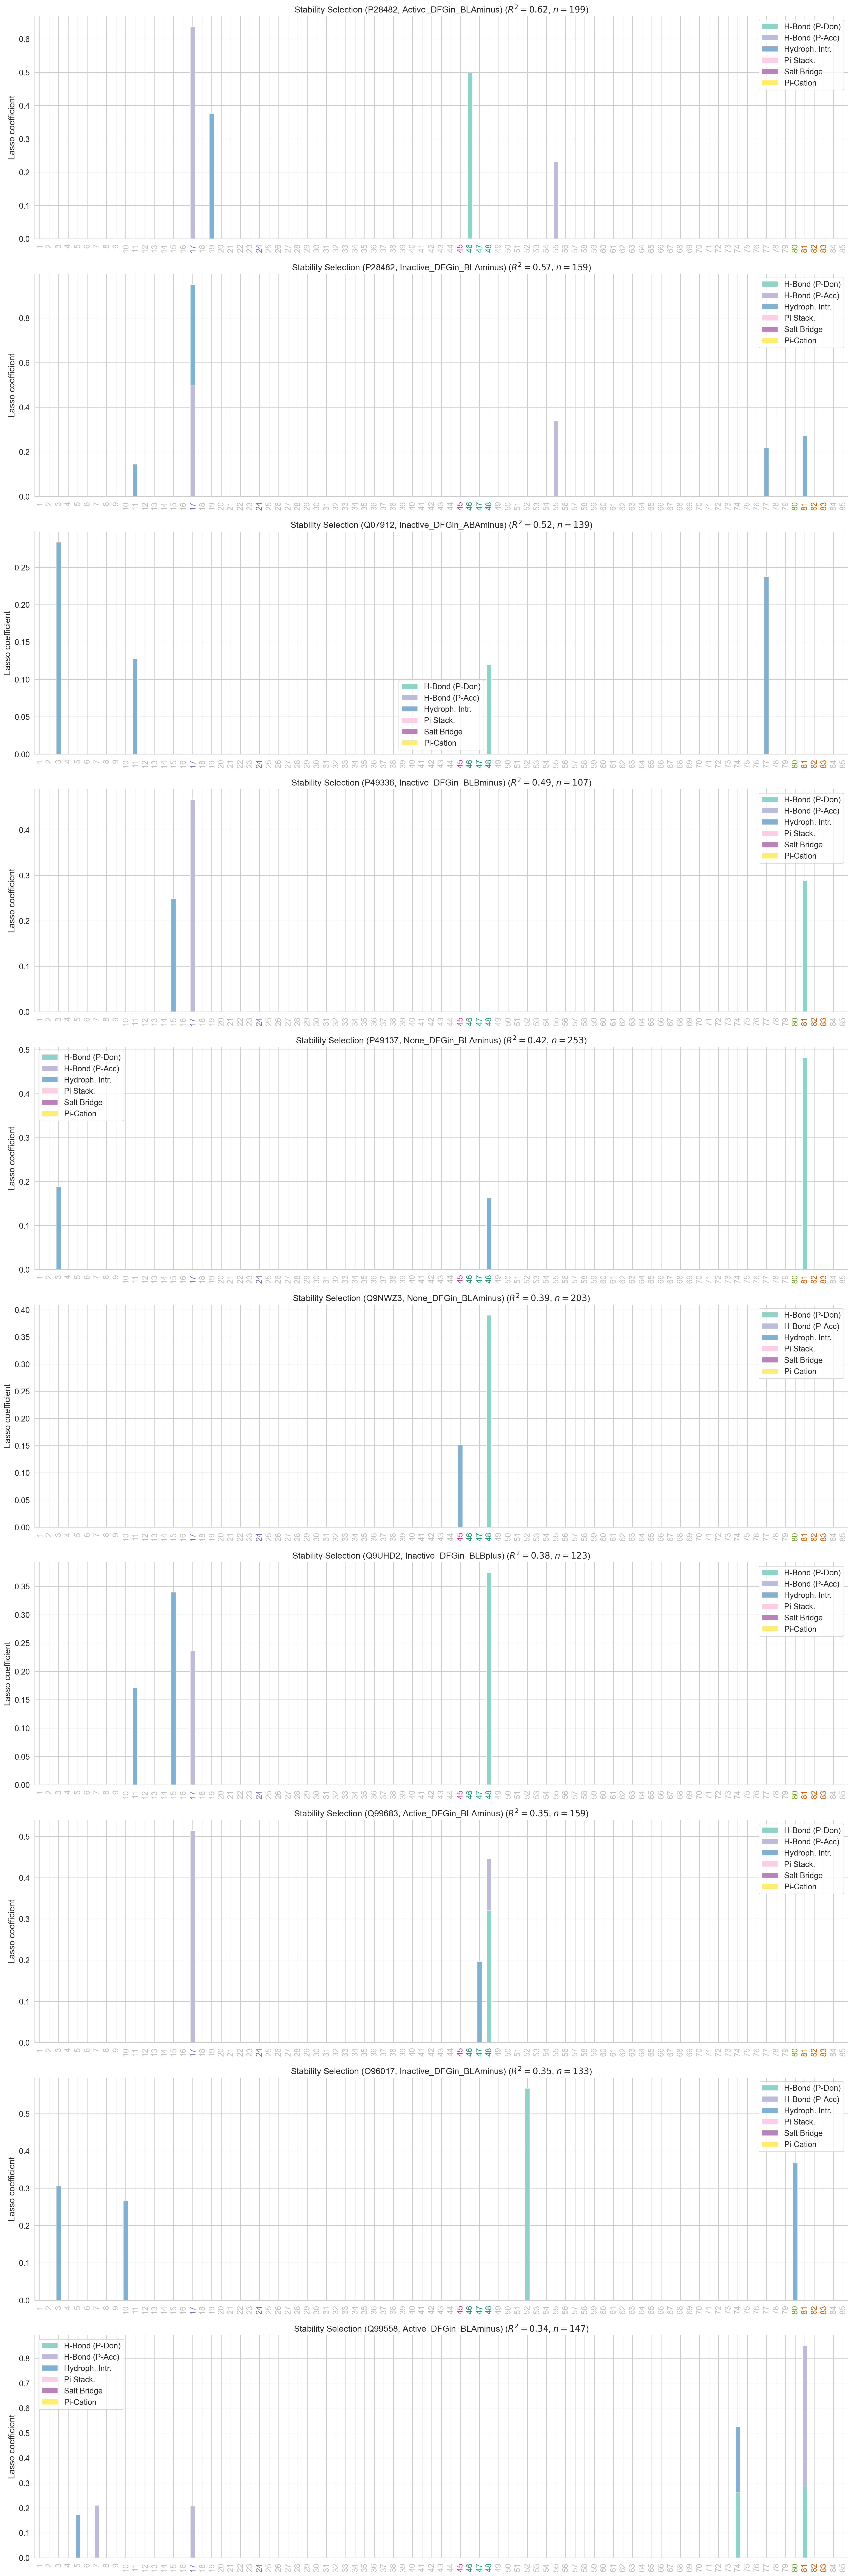

In [10]:
MODELS_FOR_PLOTTING = 10
models_for_plotting = selected_models[:MODELS_FOR_PLOTTING]

sns.set_style("whitegrid")
sns.set_context(context="paper", font_scale=1.5)

fig, axes = plt.subplots(
    len(models_for_plotting), 1, figsize=(20, 6 * len(models_for_plotting)), dpi=200
)
ITR_TYPES = [
    "H-Bond",
    "H-Bond (P-Don)",
    "H-Bond (P-Acc)",
    "Hydroph. Intr.",
    "Pi Stack.",
    "Salt Bridge",
    # "Halogen Bond",
    "Pi-Cation",
]
lasso_dfs = []
for model_info in selected_models:
    importances = model_info.coefs_in_pic50.reshape(6, 85)
    df_lasso = defaultdict(list)
    h_bonds_total = importances[[0, 1], :].sum(axis=0)
    h_bonds_total = h_bonds_total.reshape(1, 85)
    importances = np.concatenate([h_bonds_total, importances], axis=0)
    for importance_vector, itr_type in zip(
        importances,
        ITR_TYPES,
    ):
        df_lasso[itr_type].extend(list(importance_vector))
    df_lasso = pd.DataFrame(df_lasso)
    df_lasso.set_index(np.arange(1, 86), inplace=True)
    df_lasso["UniprotID"] = model_info.uniprot_id
    df_lasso[cmn.COLS.DUNBRACK_SIMPLIFIED] = model_info.dunbrack_state
    df_lasso["n"] = model_info.n
    df_lasso["r2"] = model_info.r2
    lasso_dfs.append(df_lasso)


for ax, model_info, df_lasso in zip(axes, models_for_plotting, lasso_dfs):
    df_lasso[ITR_TYPES[1:]].plot.bar(
        ax=ax, stacked=True, zorder=1, colormap=cmn.interaction_cm
    )
    # ax.set_ylim(0, max(1, max_abs_coef))
    ax.hlines(0, 0, 86, color="grey", linestyle="--", alpha=0.5)
    # ax.hlines(0.95, 0, 86, color="red", alpha=0.5)
    # ax.hlines(1, 0, 86, color="red", linestyle="--", alpha=0.5)
    # for region in kinase_regions.values():
    #     for resnr in region:
    #         ax.vlines(
    #             resnr - 1,
    #             0,
    #             max(1, max_abs_coef),
    #             color=RESIDUE_COLORS[resnr - 1],
    #             alpha=0.2,
    #             linewidth=8,
    #             zorder=0,
    #         )
    cmn.add_kinase_coloring(ax, draw_legend=False)
    plt.tight_layout()
    ax.set_title(
        f"Stability Selection ({model_info.uniprot_id}, {model_info.dunbrack_state}) ($R^2 = {model_info.r2:.2f}$, $n = {model_info.n}$)"
    )
    ax.set_ylabel("Lasso coefficient")
    sns.despine(ax=ax)

cmn.write_figure("stability_selection_example_models", fig)


In [11]:
stability_selection_data = pd.concat(lasso_dfs)
stability_selection_data = stability_selection_data.reset_index().rename(
    columns={"index": "RESNR"}
)
stability_selection_data = stability_selection_data[
    stability_selection_data[ITR_TYPES[1:]].sum(axis=1) > 0
]

In [12]:
stability_selection_data["r2"].min()

np.float64(0.20256880623360674)

In [13]:
num_complexes = stability_selection_data.drop_duplicates(
    subset=["UniprotID", cmn.COLS.DUNBRACK_SIMPLIFIED]
)["n"].sum()
k3d_fraction = num_complexes / kinodata3d[cmn.COLS.ACTIVITY_ID].nunique() * 100
num_residues = stability_selection_data.shape[0]
# num_klifs_structures = bs_lasso_results["similar.klifs_structure_id"].nunique()
num_kinases = stability_selection_data["UniprotID"].nunique()

print(
    f"Mined {num_residues} important residues in {num_kinases} unique UniProt kinases covering {num_complexes} ({k3d_fraction:.1f} %) kinodata3D complexes."
)

Mined 132 important residues in 29 unique UniProt kinases covering 9763 (8.2 %) kinodata3D complexes.


In [14]:
stability_selection_data

,RESNR,H-Bond,H-Bond (P-Don),H-Bond (P-Acc),Hydroph. Intr.,Pi Stack.,Salt Bridge,Pi-Cation,UniprotID,dunbrack_simplified,n,r2
16,17,0.636933,0.000000,0.636933,0.000000,0.0,0.0,0.0,P28482,Active_DFGin_BLAminus,199,0.616475
18,19,0.000000,0.000000,0.000000,0.376981,0.0,0.0,0.0,P28482,Active_DFGin_BLAminus,199,0.616475
45,46,0.498143,0.498143,0.000000,0.000000,0.0,0.0,0.0,P28482,Active_DFGin_BLAminus,199,0.616475
54,55,0.232228,0.000000,0.232228,0.000000,0.0,0.0,0.0,P28482,Active_DFGin_BLAminus,199,0.616475
95,11,0.000000,0.000000,0.000000,0.144430,0.0,0.0,0.0,P28482,Inactive_DFGin_BLAminus,159,0.567400
...,...,...,...,...,...,...,...,...,...,...,...,...
2885,81,0.341960,0.000000,0.341960,0.000000,0.0,0.0,0.0,Q05397,Inactive_DFGin_None,317,0.205099
2897,8,0.000000,0.000000,0.000000,0.395628,0.0,0.0,0.0,P51812,Inactive_DFGin_ABAminus,103,0.202569
2925,36,0.000000,0.000000,0.000000,0.367547,0.0,0.0,0.0,P51812,Inactive_DFGin_ABAminus,103,0.202569
2937,48,0.514750,0.308283,0.206467,0.000000,0.0,0.0,0.0,P51812,Inactive_DFGin_ABAminus,103,0.202569


In [15]:
import copy

itr_type_freq = copy.deepcopy(stability_selection_data).drop(columns=["H-Bond"])
for itpye in ITR_TYPES[1:]:
    itr_type_freq[itpye] = (itr_type_freq[itpye] > 0).astype(int)

itr_type_freq = (
    itr_type_freq.groupby("RESNR")[ITR_TYPES[1:]]
    .sum()
    .reindex(range(1, 86), fill_value=0)
)

In [16]:
stability_selection_data

,RESNR,H-Bond,H-Bond (P-Don),H-Bond (P-Acc),Hydroph. Intr.,Pi Stack.,Salt Bridge,Pi-Cation,UniprotID,dunbrack_simplified,n,r2
16,17,0.636933,0.000000,0.636933,0.000000,0.0,0.0,0.0,P28482,Active_DFGin_BLAminus,199,0.616475
18,19,0.000000,0.000000,0.000000,0.376981,0.0,0.0,0.0,P28482,Active_DFGin_BLAminus,199,0.616475
45,46,0.498143,0.498143,0.000000,0.000000,0.0,0.0,0.0,P28482,Active_DFGin_BLAminus,199,0.616475
54,55,0.232228,0.000000,0.232228,0.000000,0.0,0.0,0.0,P28482,Active_DFGin_BLAminus,199,0.616475
95,11,0.000000,0.000000,0.000000,0.144430,0.0,0.0,0.0,P28482,Inactive_DFGin_BLAminus,159,0.567400
...,...,...,...,...,...,...,...,...,...,...,...,...
2885,81,0.341960,0.000000,0.341960,0.000000,0.0,0.0,0.0,Q05397,Inactive_DFGin_None,317,0.205099
2897,8,0.000000,0.000000,0.000000,0.395628,0.0,0.0,0.0,P51812,Inactive_DFGin_ABAminus,103,0.202569
2925,36,0.000000,0.000000,0.000000,0.367547,0.0,0.0,0.0,P51812,Inactive_DFGin_ABAminus,103,0.202569
2937,48,0.514750,0.308283,0.206467,0.000000,0.0,0.0,0.0,P51812,Inactive_DFGin_ABAminus,103,0.202569


/var/folders/gp/_kdyh3hn1yv47p6w56krv9000000gn/T/ipykernel_46312/3745607924.py:99: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([f"{v:.1f}" for v in ax1.get_xticks()], fontsize=20)
2025-11-03 14:20:09,155 - Writing figure to /Users/joschkagross/projects/kinodata-pli-alignment/data/figures/results_stability_selection.svg ...
2025-11-03 14:20:09,320 - Writing figure to /Users/joschkagross/projects/kinodata-pli-alignment/data/figures/results_stability_selection.pdf ...
2025-11-03 14:20:09,496 - Writing figure to /Users/joschkagross/projects/kinodata-pli-alignment/data/figures/results_stability_selection.png ...


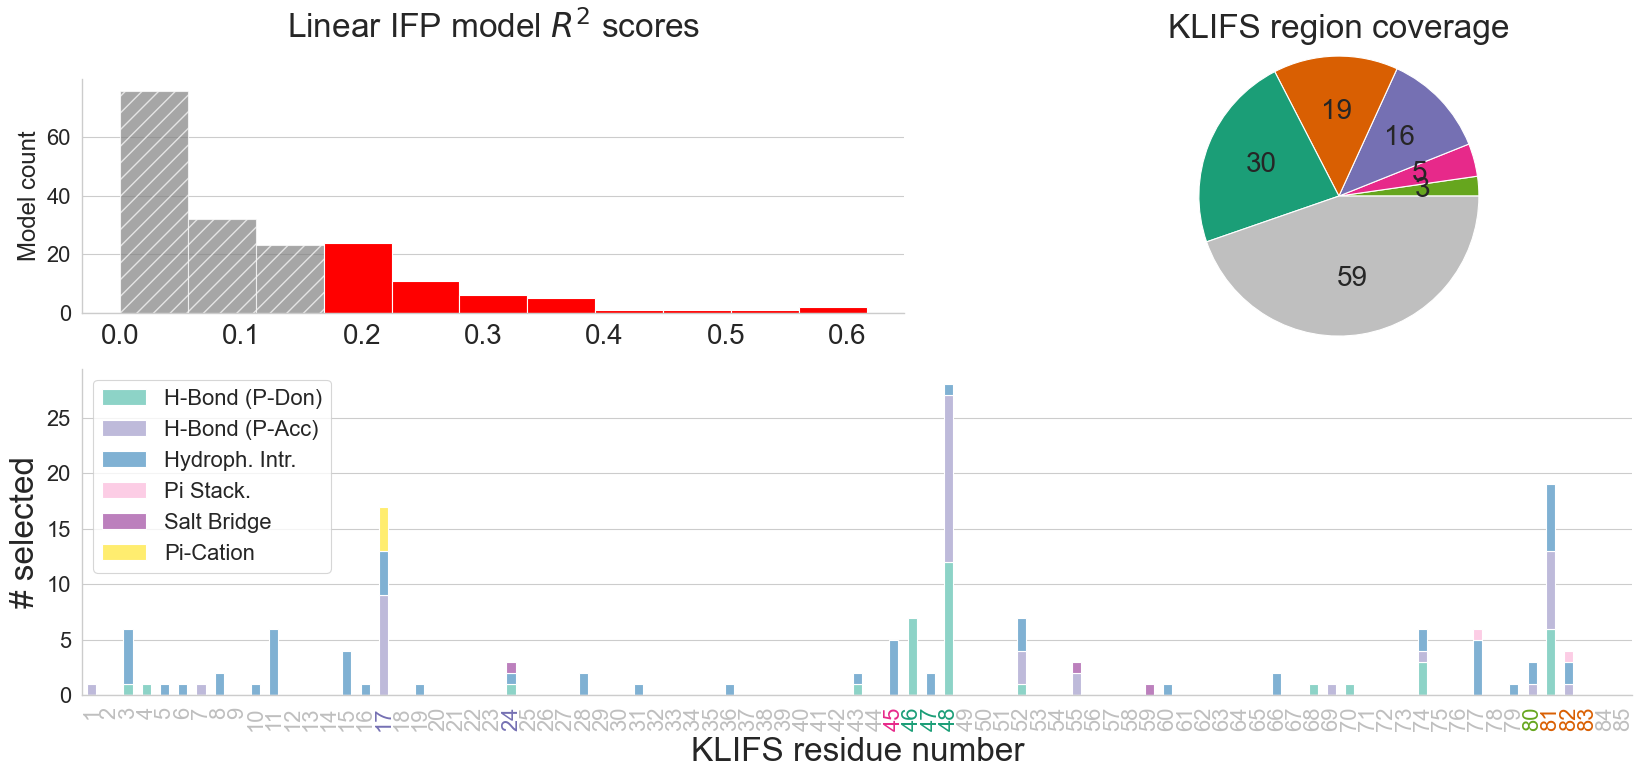

In [17]:
from matplotlib.gridspec import GridSpec

PLOT_FREQS = True
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.8)

fig = plt.figure(figsize=(20, 8))
gs = GridSpec(2, 2, height_ratios=[1, 1.4], width_ratios=[1.4, 1])

# Create axes
ax1 = fig.add_subplot(gs[0, 0])  # Top-left
ax2 = fig.add_subplot(gs[0, 1])  # Top-right
ax3 = fig.add_subplot(gs[1, :])  # Bottom-left

if PLOT_FREQS:
    itr_type_freq.plot.bar(ax=ax3, stacked=True, colormap=cmn.interaction_cm)
    max_abs_coef = itr_type_freq.sum(axis=1).max()
    lower_lim = 0
    upper_lim = max(1, max_abs_coef)

else:
    stability_selection_data.groupby("RESNR").size().reindex(
        range(1, 86), fill_value=0
    ).plot.bar(ax=ax, color=cmn.residue_colors)
    max_count = stability_selection_data.groupby("RESNR").size().max()
    lower_lim = 0
    upper_lim = max_count + 5
# for region in cmn.kinase_regions.values():
#     for resnr in region:
#         ax.vlines(
#             resnr - 1,
#             lower_lim,
#             upper_lim,
#             color=cmn.residue_colors[resnr - 1],
#             alpha=0.15,
#             linewidth=8,
#             zorder=0,
#         )
# ax.set_ylim(lower_lim, upper_lim)
if PLOT_FREQS:
    ax3.set_ylabel(
        "# selected",
        fontdict={"fontsize": 24},
    )
    ax3.set_xlabel(
        "KLIFS residue number",
        fontdict={"fontsize": 24},
    )
else:
    ...
cmn.add_kinase_coloring(ax3, draw_legend=False)


def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        return "{v:d}".format(v=val)

    return my_format


selected_residue_locations = (
    stability_selection_data.groupby("RESNR")
    .size()
    .reindex(range(1, 86), fill_value=0)
    .to_frame()
)
selected_residue_locations.rename(columns={0: "count"}, inplace=True)
selected_residue_locations["region"] = selected_residue_locations.index.map(
    lambda x: cmn.residue_number_to_region.get(x, "other")
)
count_by_region = (
    selected_residue_locations.groupby("region")["count"].sum().sort_values()
)
_ = ax2.pie(
    count_by_region,
    radius=1.5,
    # labels=count_by_region.index,
    autopct=autopct_format(count_by_region),
    colors=cmn.region_colors[count_by_region.index],
    textprops=dict(fontsize=20),
)
ax2.set_title(
    f"KLIFS region coverage",
    pad=30,
    fontdict={"fontsize": 24},
)

r2s = np.array([max(0, info.r2) for info in models])

sns.histplot(r2s, ax=ax1, alpha=1, color="black")
ax1.set_title(
    # f"Stability Selection $R^2$ scores (average {np.mean(r2s):.2f})",
    f"Linear IFP model $R^2$ scores",
    pad=30,
    fontdict={"fontsize": 24},
)
ax1.set_xticklabels([f"{v:.1f}" for v in ax1.get_xticks()], fontsize=20)
ax1.set_ylabel("Model count")
for patch in ax1.patches:
    bin_left = patch.get_x()
    bin_width = patch.get_width()
    bin_center = bin_left + bin_width / 2

    if bin_center >= 0.19:
        patch.set_facecolor("red")
    else:
        patch.set_facecolor("grey")
        patch.set_hatch("//")
        patch.set_alpha(0.7)

sns.despine(ax=ax1)
sns.despine(ax=ax3)
ax1.grid(axis="x")
ax3.grid(axis="x")
# sns.move_legend(ax3, "upper left", bbox_to_anchor=(0.25, 1.1), title="Interaction Type")
cmn.write_figure("results_stability_selection", fig)

In [18]:
stability_selection_data.to_csv(
    cmn.DATA_PATH / "processed" / "stability_selection_results.csv",
    index=False,
)

### Create PLI reference attributions for covered part of kinodata3d

In [19]:
pli_reference = kinodata3d[
    [cmn.COLS.DUNBRACK_SIMPLIFIED, cmn.COLS.ACTIVITY_ID, "UniprotID"]
].merge(
    stability_selection_data.drop(columns=["H-Bond"]),
    how="inner",
    on=[cmn.COLS.DUNBRACK_SIMPLIFIED, "UniprotID"],
)
pli_reference.head()

,dunbrack_simplified,activities.activity_id,UniprotID,RESNR,H-Bond (P-Don),H-Bond (P-Acc),Hydroph. Intr.,Pi Stack.,Salt Bridge,Pi-Cation,n,r2
0,Inactive_DFGin_BLBtrans,34039,P00533,47,0.0,0.000000,0.248817,0.0,0.000000,0.0,719,0.220432
1,Inactive_DFGin_BLBtrans,34039,P00533,48,0.0,0.414885,0.000000,0.0,0.000000,0.0,719,0.220432
2,Inactive_DFGin_BLBtrans,34039,P00533,52,0.0,0.207181,0.000000,0.0,0.000000,0.0,719,0.220432
3,Inactive_DFGin_BLBtrans,34039,P00533,55,0.0,0.000000,0.000000,0.0,0.369959,0.0,719,0.220432
4,Inactive_DFGin_BLBtrans,34039,P00533,80,0.0,0.000000,0.145934,0.0,0.000000,0.0,719,0.220432


In [20]:
pli_fixed = defaultdict(list)
for _, row in pli_reference.iterrows():
    lasso_coef = row[ITR_TYPES[1:]].values
    resnr = row["RESNR"]
    activity_id = row[cmn.COLS.ACTIVITY_ID]
    try:
        ifp = (
            dunbrack_fp_data.loc[activity_id]
            .values[:510]
            .reshape(6, 85)
            .astype(np.float32)
        )
    except KeyError:
        continue
    contribution_map = ifp[:, resnr - 1] * lasso_coef
    for itr_type, contrib in zip(ITR_TYPES[1:], contribution_map):
        pli_fixed[itr_type].append(contrib)
    pli_fixed["residue_importance"].append(contribution_map.sum())
    pli_fixed["residue_number"].append(resnr)
    pli_fixed[cmn.COLS.DUNBRACK_SIMPLIFIED].append(row[cmn.COLS.DUNBRACK_SIMPLIFIED])
    pli_fixed["UniprotID"].append(row["UniprotID"])
    pli_fixed[cmn.COLS.ACTIVITY_ID].append(activity_id)
    pli_fixed["n"].append(row["n"])
    pli_fixed["r2"].append(row["r2"])

In [21]:
pli_fixed = pd.DataFrame(pli_fixed)
pli_fixed.head()

,H-Bond (P-Don),H-Bond (P-Acc),Hydroph. Intr.,Pi Stack.,Salt Bridge,Pi-Cation,residue_importance,residue_number,dunbrack_simplified,UniprotID,activities.activity_id,n,r2
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47,Inactive_DFGin_BLBtrans,P00533,34039,719,0.220432
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48,Inactive_DFGin_BLBtrans,P00533,34039,719,0.220432
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52,Inactive_DFGin_BLBtrans,P00533,34039,719,0.220432
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55,Inactive_DFGin_BLBtrans,P00533,34039,719,0.220432
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80,Inactive_DFGin_BLBtrans,P00533,34039,719,0.220432


In [22]:
pli_fixed = pli_fixed[pli_fixed["residue_importance"] > 1e-3]

2025-11-03 14:20:22,161 - Writing figure to /Users/joschkagross/projects/kinodata-pli-alignment/data/figures/pli_reference_residue_coverage.svg ...
2025-11-03 14:20:22,254 - Writing figure to /Users/joschkagross/projects/kinodata-pli-alignment/data/figures/pli_reference_residue_coverage.pdf ...
2025-11-03 14:20:22,351 - Writing figure to /Users/joschkagross/projects/kinodata-pli-alignment/data/figures/pli_reference_residue_coverage.png ...


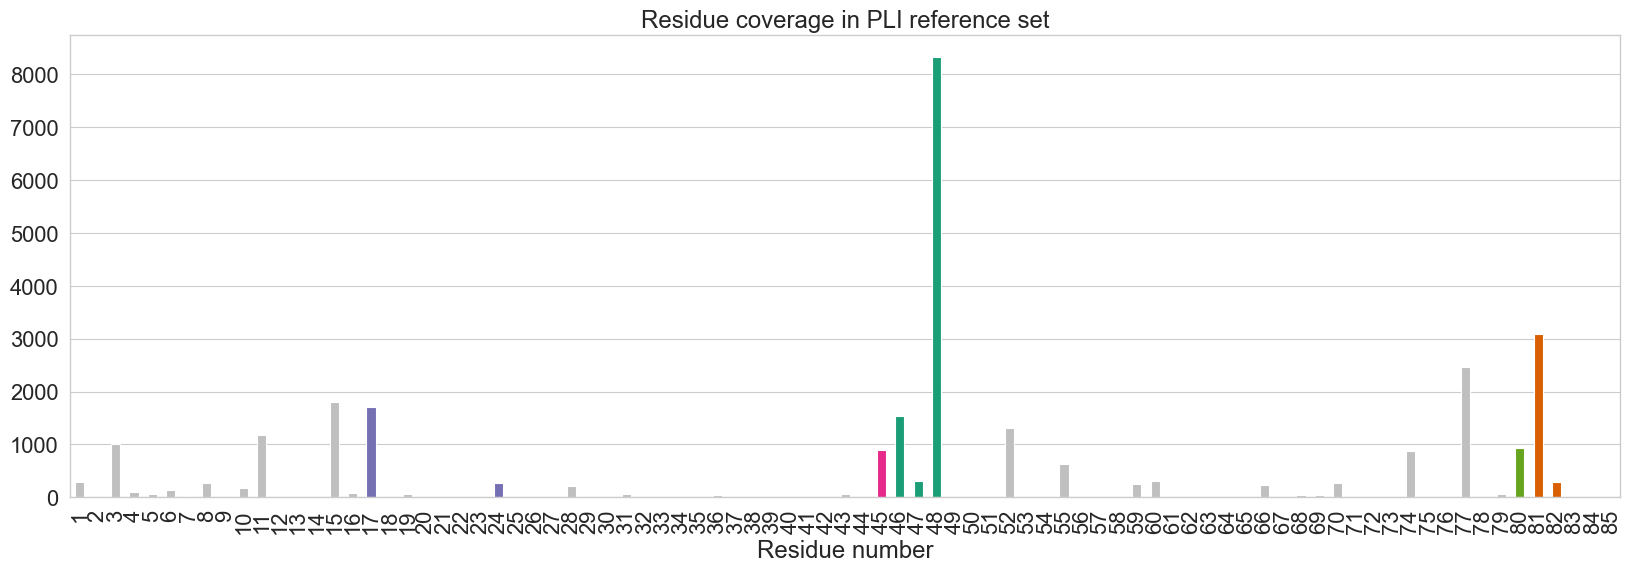

In [23]:
ax = (
    pli_fixed.groupby("residue_number")
    .size()
    .reindex(range(1, 86), fill_value=0)
    .plot.bar(
        color=cmn.residue_colors,
        figsize=(20, 6),
        title="Residue coverage in PLI reference set",
    )
)
ax.grid(axis="x")
ax.set_xlabel("Residue number")
cmn.write_figure("pli_reference_residue_coverage", fig=ax.figure)